In [4]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 24.2 MB/s eta 0:00:00


In [28]:
"""
Samsung Mobile Sales Analytics - Advanced Data Science
=====================================================

Project: Advanced Analytics on Samsung Mobile Sales Dataset (1000 rows)
Domain: Mobile Sales & Market Analytics
Author: Shubham Shirsekar
Platform: Google Colab

Advanced Analytics Modules:
1. Cohort Analysis & Product Lifetime Value
2. Temporal Affinity - Revenue Based
3. Geospatial Sales Analysis - Choropleth Visualizations
4. Temporal Choropleth Analysis and Visualization
"""

# ========================================
# SECTION 1: ENVIRONMENT SETUP
# ========================================

# Install required packages for Google Colab
import subprocess
import sys
import re
from google.colab import files

def install_packages():
    """Install required packages for Google Colab"""
    packages = [
        'plotly==5.17.0',
        'prophet==1.1.4',
        'scikit-learn==1.3.0',
        'xgboost==1.7.6',
        'seaborn==0.12.2',
        'statsmodels==0.14.0',
        'folium==0.14.0',
        'dash==2.14.1',
        'mlxtend==0.22.0',
        'lifetimes==0.11.3'
    ]

    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Uncomment the line below to install packages
# install_packages()

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from itertools import combinations
from scipy.stats import pearsonr
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Advanced Analytics Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Specialized Libraries
from mlxtend.frequent_patterns import apriori, association_rules
from lifetimes import BetaGeoFitter, GammaGammaFitter
import folium
from folium.plugins import HeatMap
import datetime as dt
from scipy import stats
from scipy.optimize import minimize_scalar

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Samsung Mobile Sales Analytics - Environment Ready!")
print("📊 Advanced Analytics Modules Loaded Successfully")


🚀 Samsung Mobile Sales Analytics - Environment Ready!
📊 Advanced Analytics Modules Loaded Successfully


In [6]:
# ========================================
# SECTION 2: DATA LOADING
# ========================================

uploaded = files.upload()

# Get the uploaded file name
csv_filename = list(uploaded.keys())[0]

# Step 2: Load CSV into DataFrame
df = pd.read_csv(csv_filename)

# Step 3: Clean column names
def clean_column_names(columns):
    cleaned = []
    for col in columns:
        # Remove leading/trailing spaces
        col = col.strip()
        # Replace spaces with underscores
        col = col.replace(" ", "_")
        # Remove special characters (keep letters, numbers, underscores)
        col = re.sub(r'[^A-Za-z0-9_]', '', col)
        # Remove trailing underscores if any
        col = col.rstrip('_')
        cleaned.append(col)
    return cleaned

df.columns = clean_column_names(df.columns)
df_sorted = df.sort_values(['Year','Quarter'])
dates = df_sorted.iloc[[0, -1]].apply(lambda x: f"{x['Quarter']} {x['Year']}", axis=1).to_list()

# Basic dataset info
print("✅ Column names:")
print(df.columns.tolist())
print(f"✅ Dataset Generated Successfully!")
print(f"📊 Shape: {df.shape}")
print(f"💼 Total Sales Value: ${df['Revenue'].sum():,.2f}")
print(f"📅 Date Range: {dates[0]} to {dates[1]}")

# Display first few rows
print("\n🔍 First 5 Records:")
display(df.head())

print("\n📋 Dataset Info:")
print(df.info())

Saving SamsungMobilePhones.csv to SamsungMobilePhones.csv
✅ Column names:
['Year', 'Quarter', 'Product_Model', '5G_Capability', 'Units_Sold', 'Revenue', 'Market_Share', 'Regional_5G_Coverage', '5G_Subscribers_millions', 'Avg_5G_Speed_Mbps', 'Preference_for_5G', 'Region']
✅ Dataset Generated Successfully!
📊 Shape: (1000, 12)
💼 Total Sales Value: $30,197,331,897.41
📅 Date Range: Q1 2019 to Q4 2024

🔍 First 5 Records:


,Year,Quarter,Product_Model,5G_Capability,Units_Sold,Revenue,Market_Share,Regional_5G_Coverage,5G_Subscribers_millions,Avg_5G_Speed_Mbps,Preference_for_5G,Region
0,2019,Q1,Galaxy S10,No,26396,4.212951e+06,1.04,57.36,39.55,293.10,55.87,Asia-Pacific
1,2019,Q1,Galaxy Note10,No,25671,7.240266e+06,2.82,85.80,42.58,67.46,37.26,Latin America
2,2019,Q1,Galaxy S20,No,16573,2.560833e+07,-0.03,47.02,3.78,77.25,84.66,Middle East & Africa
3,2019,Q1,Galaxy Note20,No,7177,2.198442e+07,0.84,25.70,23.41,105.27,40.03,North America
4,2019,Q1,Galaxy S21,No,45633,1.634244e+07,2.36,89.13,44.43,206.17,76.88,Latin America



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     1000 non-null   int64  
 1   Quarter                  1000 non-null   object 
 2   Product_Model            1000 non-null   object 
 3   5G_Capability            1000 non-null   object 
 4   Units_Sold               1000 non-null   int64  
 5   Revenue                  1000 non-null   float64
 6   Market_Share             1000 non-null   float64
 7   Regional_5G_Coverage     1000 non-null   float64
 8   5G_Subscribers_millions  1000 non-null   float64
 9   Avg_5G_Speed_Mbps        1000 non-null   float64
 10  Preference_for_5G        1000 non-null   float64
 11  Region                   1000 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 93.9+ KB
None


🔄 Performing Regional Cohort Analysis...


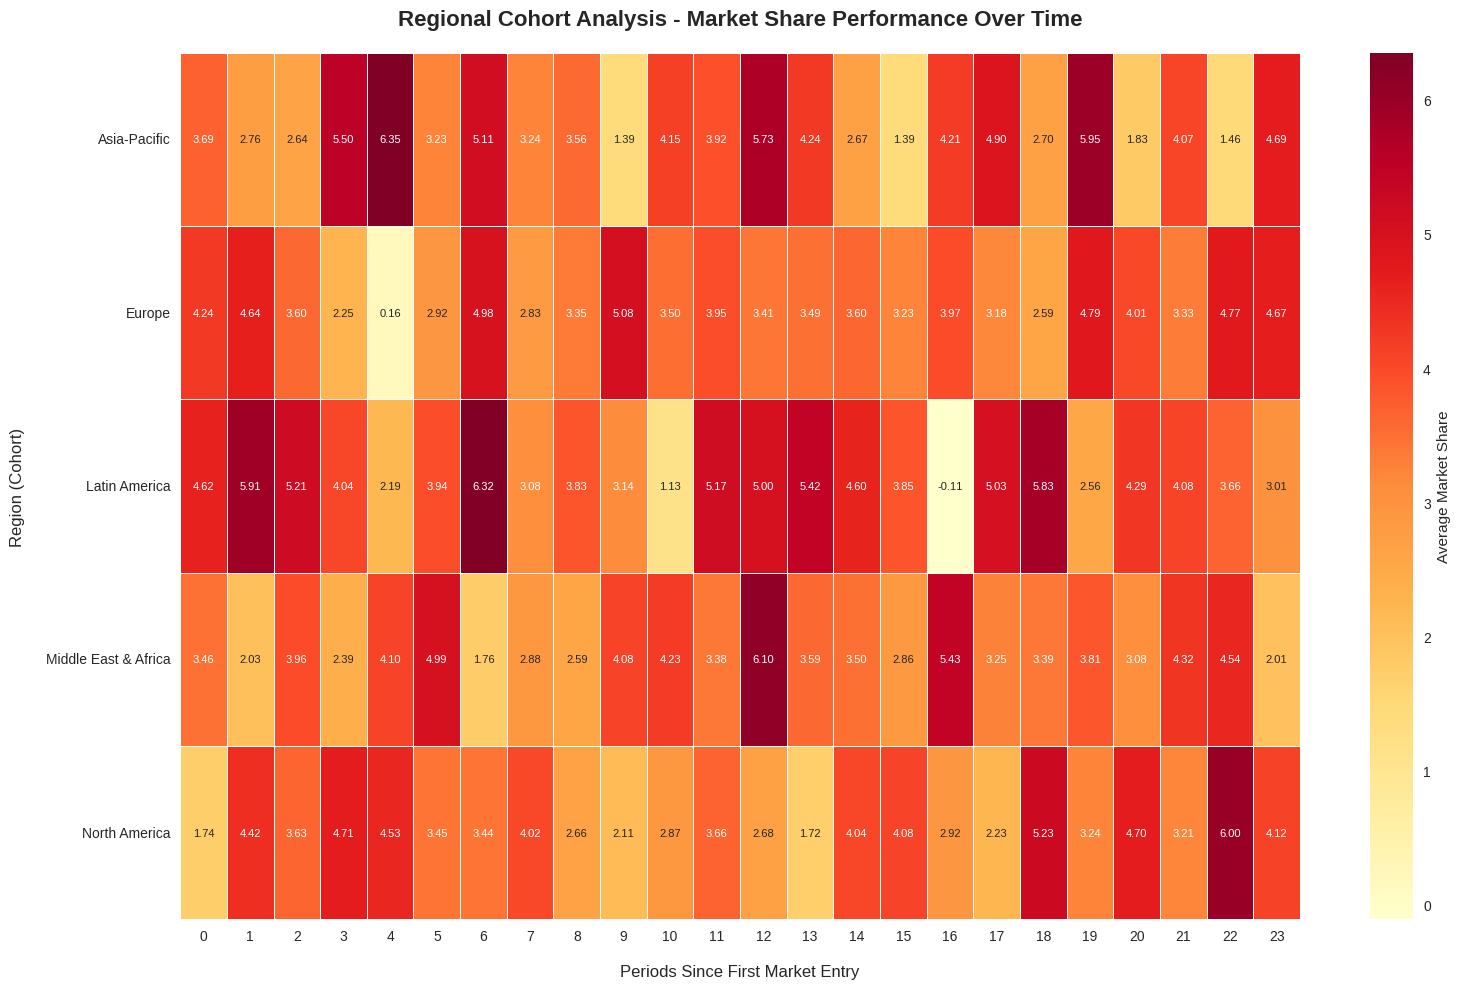


📊 Cohort Analysis Summary:
Number of regional cohorts: 5
Maximum tracking period: 23 periods
Average initial market share: 3.550
Best performing region in final period: Asia-Pacific
💰 Calculating Product Lifetime Value Analysis...


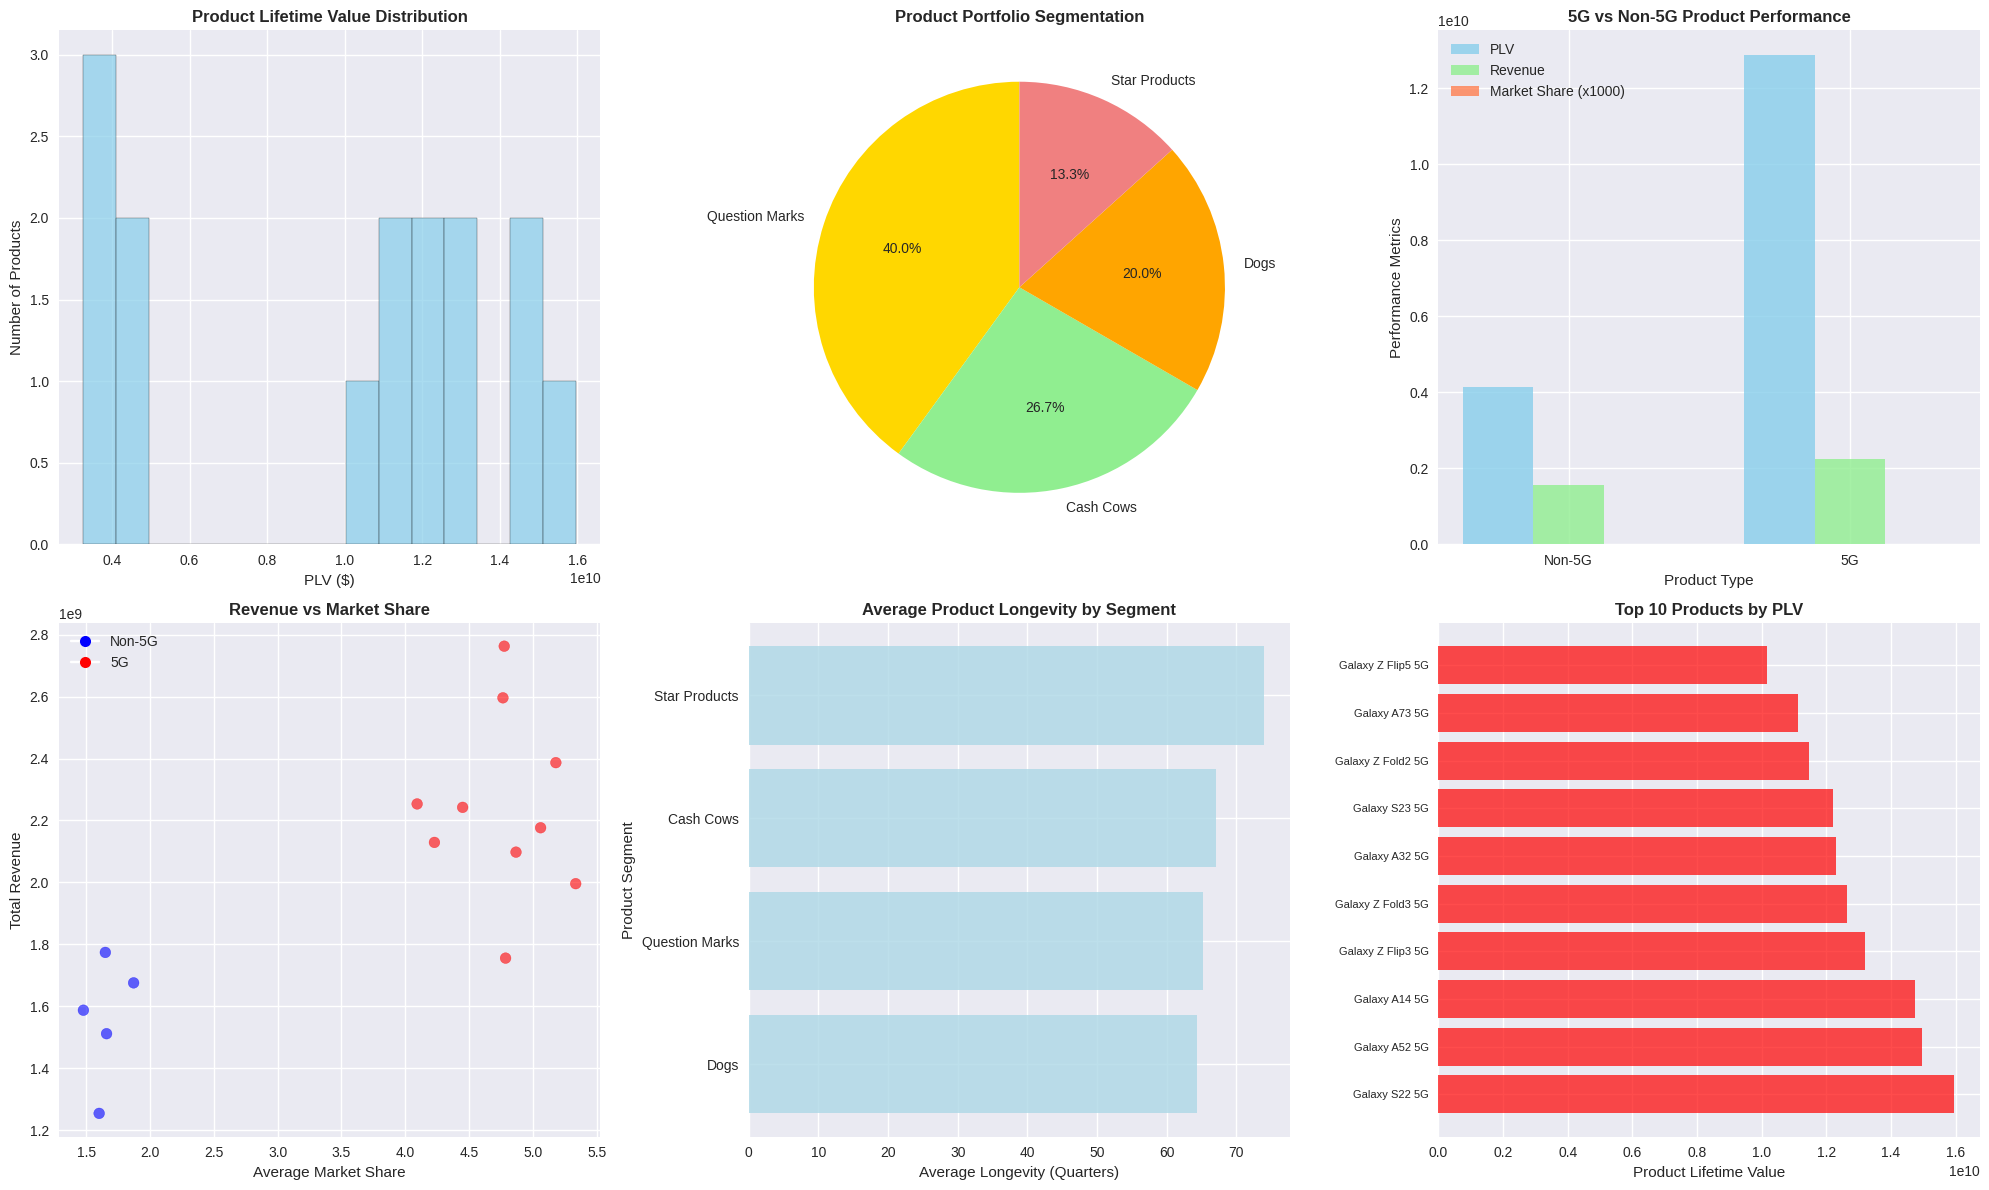


📊 Product Portfolio Summary:
Total Products Analyzed: 15
5G Products: 10 (66.7%)
Average PLV: $9,968,150,354.54
Top Product PLV: $15,954,899,954.60

🏆 Segment Performance:
                      Avg_PLV  Count
Product_Segment                     
Star Products    1.457196e+10      2
Cash Cows        1.366603e+10      4
Question Marks   9.082732e+09      6
Dogs             3.739272e+09      3

🎯 Best Performing Product: Galaxy S22 5G


In [9]:
# ========================================
# SECTION 3: ADVANCED ANALYTICS MODULE 1
# COHORT ANALYSIS & PRODUCT LIFETIME VALUE
# ========================================

def cohort_analysis(df):
    """
    Track customers by their first purchase region and see retention patterns
    using market share as a proxy for regional performance over time.
    """
    print("🔄 Performing Regional Cohort Analysis...")

    # Create time mapping
    quarter_map = {"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4}
    df['Time_Code'] = df['Year'] * 4 + df['Quarter'].map(quarter_map)

    # First appearance of each region (cohort definition)
    first_quarter = df.groupby('Region')['Time_Code'].min().reset_index()
    first_quarter.columns = ['Region', 'Cohort_Period']

    # Merge cohort info back to main dataframe
    df = df.merge(first_quarter, on='Region')
    df['Period_Number'] = df['Time_Code'] - df['Cohort_Period']

    # Calculate cohort table using market share
    cohort_table = df.pivot_table(
        index='Region',
        columns='Period_Number',
        values='Market_Share',
        aggfunc='mean'
    )

    # Fill NaN values with 0 for better visualization
    cohort_table_filled = cohort_table.fillna(0)

    # Create the heatmap
    plt.figure(figsize=(16, 10))

    # Create heatmap
    sns.heatmap(
        cohort_table_filled,
        annot=True,
        cmap='YlOrRd',  # Better color scheme for market share
        fmt='.2f',      # Format as decimal (market share is typically 0-1 or percentage)
        cbar_kws={'label': 'Average Market Share'},
        annot_kws={
            'size': 8,      # Readable text size
            'va': 'center',
            'ha': 'center'
        },
        linewidths=0.5,  # Add grid lines for clarity
        square=False     # Allow rectangular cells
    )

    # Customize the plot
    plt.title('Regional Cohort Analysis - Market Share Performance Over Time',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Periods Since First Market Entry', fontsize=12, labelpad=15)
    plt.ylabel('Region (Cohort)', fontsize=12, labelpad=15)

    # Rotate y-axis labels for better readability
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\n📊 Cohort Analysis Summary:")
    print(f"Number of regional cohorts: {len(cohort_table.index)}")
    print(f"Maximum tracking period: {cohort_table.columns.max()} periods")
    print(f"Average initial market share: {cohort_table.iloc[:, 0].mean():.3f}")

    # Show which regions had the best performance in later periods
    if len(cohort_table.columns) > 1:
        final_period = cohort_table.columns[-1]
        best_performer = cohort_table[final_period].idxmax()
        print(f"Best performing region in final period: {best_performer}")

    return cohort_table

def product_lifetime_value_analysis(df):
    """
    Calculate Product Lifetime Value and Performance Metrics
    Analyzes how products perform across their lifecycle
    """
    print("💰 Calculating Product Lifetime Value Analysis...")

    # Create time mapping
    quarter_map = {"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4}
    df['Time_Code'] = df['Year'] * 4 + df['Quarter'].map(quarter_map)

    # Calculate product metrics (similar to RFM but for products)
    product_metrics = df.groupby('Product_Model').agg({
        'Time_Code': ['min', 'max', 'count'],  # Launch period, latest period, longevity
        'Units_Sold': ['sum', 'mean', 'max'],  # Total, average, peak sales
        'Revenue': ['sum', 'mean', 'max'],     # Total, average, peak revenue
        'Market_Share': ['mean', 'max', 'std'] # Average, peak, volatility
    }).reset_index()

    # Flatten column names
    product_metrics.columns = [
        'Product_Model', 'Launch_Period', 'Latest_Period', 'Longevity',
        'Total_Units', 'Avg_Units', 'Peak_Units',
        'Total_Revenue', 'Avg_Revenue', 'Peak_Revenue',
        'Avg_Market_Share', 'Peak_Market_Share', 'Market_Share_Volatility'
    ]

    # Calculate Product Lifetime Value (PLV)
    product_metrics['Product_Age'] = product_metrics['Latest_Period'] - product_metrics['Launch_Period'] + 1
    product_metrics['Revenue_per_Period'] = product_metrics['Total_Revenue'] / product_metrics['Longevity']
    product_metrics['PLV'] = product_metrics['Total_Revenue'] * (1 + product_metrics['Avg_Market_Share'])

    # Add 5G capability info
    product_5g = df.groupby('Product_Model')['5G_Capability'].first().reset_index()
    # Convert 5G_Capability to boolean format for consistent handling
    def standardize_5g_capability(value):
        if isinstance(value, bool):
            return value
        elif isinstance(value, str):
            return value.lower() in ['true', 'yes', '1', 'y']
        else:
            return bool(value)

    product_5g['5G_Capability'] = product_5g['5G_Capability'].apply(standardize_5g_capability)
    product_metrics = product_metrics.merge(product_5g, on='Product_Model')

    # Create performance scores (1-5 scale)
    product_metrics['Revenue_Score'] = pd.qcut(product_metrics['Total_Revenue'], 5, labels=[1,2,3,4,5])
    product_metrics['Longevity_Score'] = pd.qcut(product_metrics['Longevity'], 5, labels=[1,2,3,4,5])
    product_metrics['Market_Share_Score'] = pd.qcut(product_metrics['Avg_Market_Share'], 5, labels=[1,2,3,4,5])

    # Product segmentation
    def segment_products(row):
        score = int(row['Revenue_Score']) + int(row['Longevity_Score']) + int(row['Market_Share_Score'])
        if score >= 13:
            return 'Star Products'
        elif score >= 10:
            return 'Cash Cows'
        elif score >= 7:
            return 'Question Marks'
        else:
            return 'Dogs'

    product_metrics['Product_Segment'] = product_metrics.apply(segment_products, axis=1)

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. PLV Distribution
    axes[0,0].hist(product_metrics['PLV'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Product Lifetime Value Distribution', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('PLV ($)')
    axes[0,0].set_ylabel('Number of Products')

    # 2. Product Segments
    segment_counts = product_metrics['Product_Segment'].value_counts()
    colors = ['gold', 'lightgreen', 'orange', 'lightcoral']
    axes[0,1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
                  colors=colors, startangle=90)
    axes[0,1].set_title('Product Portfolio Segmentation', fontsize=12, fontweight='bold')

    # 3. 5G vs Non-5G Performance
    performance_5g = product_metrics.groupby('5G_Capability').agg({
        'PLV': 'mean',
        'Total_Revenue': 'mean',
        'Avg_Market_Share': 'mean'
    })

    x = ['Non-5G', '5G']
    width = 0.25
    x_pos = np.arange(len(x))

    axes[0,2].bar(x_pos - width, performance_5g['PLV'], width, label='PLV', alpha=0.8, color='skyblue')
    axes[0,2].bar(x_pos, performance_5g['Total_Revenue'], width, label='Revenue', alpha=0.8, color='lightgreen')
    axes[0,2].bar(x_pos + width, performance_5g['Avg_Market_Share']*1000, width, label='Market Share (x1000)', alpha=0.8, color='coral')

    axes[0,2].set_title('5G vs Non-5G Product Performance', fontsize=12, fontweight='bold')
    axes[0,2].set_xlabel('Product Type')
    axes[0,2].set_ylabel('Performance Metrics')
    axes[0,2].set_xticks(x_pos)
    axes[0,2].set_xticklabels(x)
    axes[0,2].legend()

    # 4. Revenue vs Market Share Scatter
    colors_5g = ['red' if x else 'blue' for x in product_metrics['5G_Capability']]
    axes[1,0].scatter(product_metrics['Avg_Market_Share'], product_metrics['Total_Revenue'],
                      c=colors_5g, alpha=0.6, s=60)
    axes[1,0].set_title('Revenue vs Market Share', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Average Market Share')
    axes[1,0].set_ylabel('Total Revenue')

    # Add legend for 5G
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Non-5G'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='5G')]
    axes[1,0].legend(handles=legend_elements)

    # 5. Product Longevity Analysis
    longevity_by_segment = product_metrics.groupby('Product_Segment')['Longevity'].mean().sort_values(ascending=True)
    axes[1,1].barh(longevity_by_segment.index, longevity_by_segment.values, color='lightblue', alpha=0.8)
    axes[1,1].set_title('Average Product Longevity by Segment', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Average Longevity (Quarters)')
    axes[1,1].set_ylabel('Product Segment')

    # 6. Top Performers
    top_products = product_metrics.nlargest(10, 'PLV')[['Product_Model', 'PLV', '5G_Capability']]
    colors_top = ['red' if x else 'blue' for x in top_products['5G_Capability']]

    axes[1,2].barh(range(len(top_products)), top_products['PLV'], color=colors_top, alpha=0.7)
    axes[1,2].set_title('Top 10 Products by PLV', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Product Lifetime Value')
    axes[1,2].set_yticks(range(len(top_products)))
    axes[1,2].set_yticklabels(top_products['Product_Model'], fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n📊 Product Portfolio Summary:")
    print(f"Total Products Analyzed: {len(product_metrics)}")
    # Count 5G products safely
    num_5g_products = sum(product_metrics['5G_Capability'].astype(bool))
    pct_5g_products = (num_5g_products / len(product_metrics)) * 100
    print(f"5G Products: {num_5g_products} ({pct_5g_products:.1f}%)")
    print(f"Average PLV: ${product_metrics['PLV'].mean():,.2f}")
    print(f"Top Product PLV: ${product_metrics['PLV'].max():,.2f}")

    print("\n🏆 Segment Performance:")
    segment_performance = product_metrics.groupby('Product_Segment').agg({
        'PLV': 'mean',
        'Product_Model': 'count'
    }).round(2)
    segment_performance.columns = ['Avg_PLV', 'Count']
    print(segment_performance.sort_values('Avg_PLV', ascending=False))

    print(f"\n🎯 Best Performing Product: {product_metrics.loc[product_metrics['PLV'].idxmax(), 'Product_Model']}")

    return product_metrics

# Run Cohort Analysis and CLV
cohort_results = cohort_analysis(df)
product_lifetime_value_results = product_lifetime_value_analysis(df)

📈 Performing Temporal Affinity Analysis using Revenue...
Analyzing 15 products with >= 3 periods of data


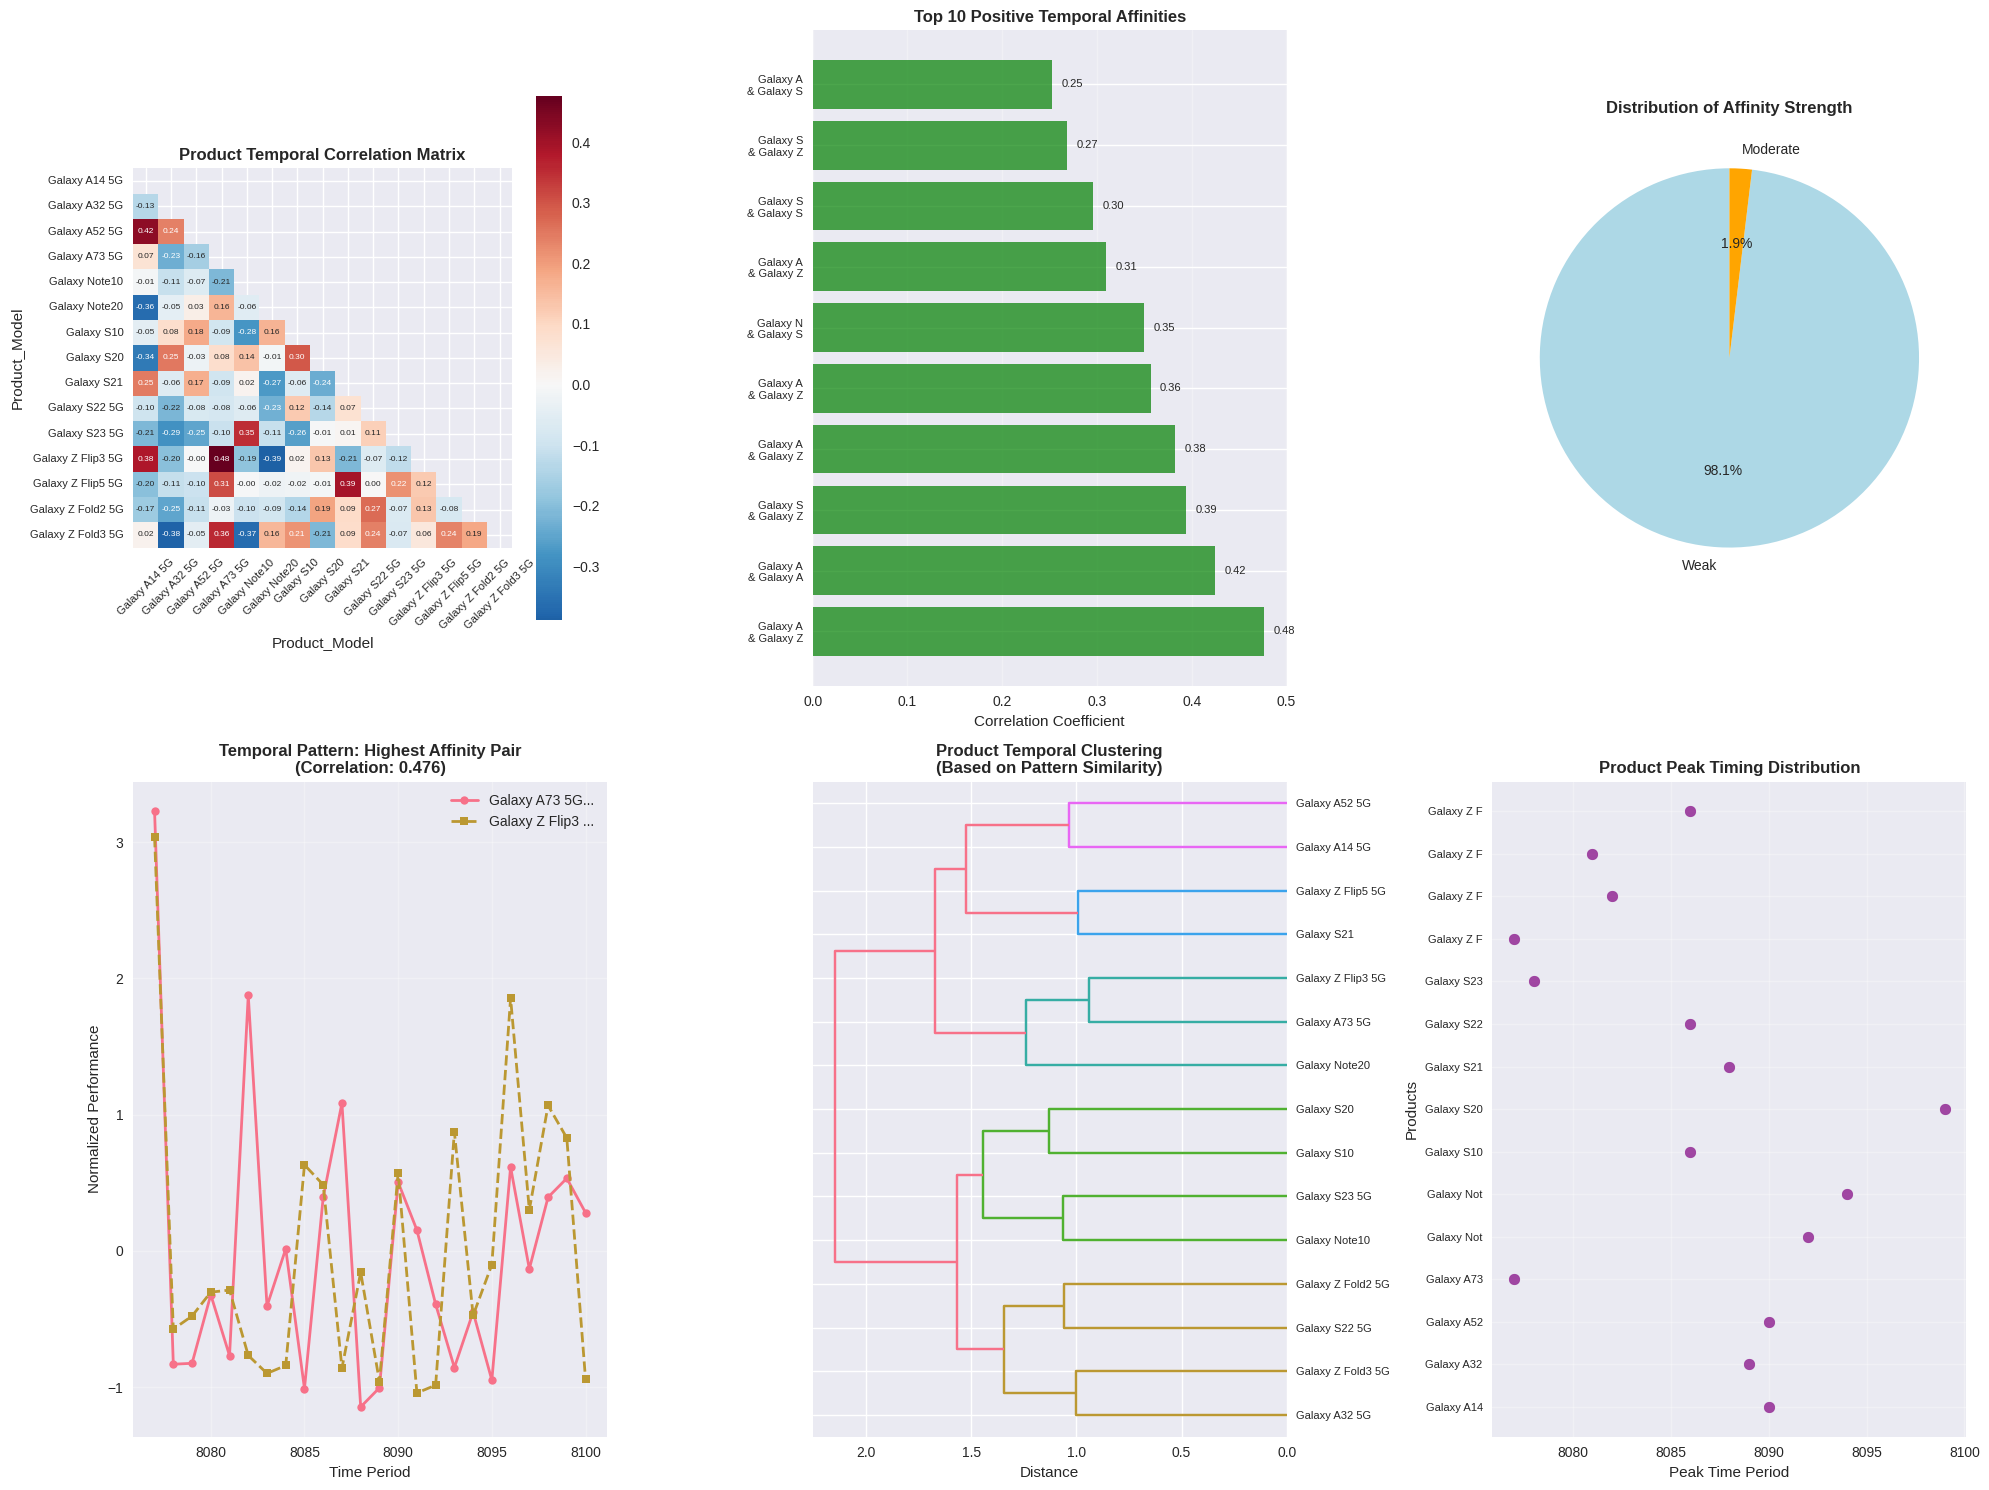


📊 Temporal Affinity Analysis Summary:
Total product pairs analyzed: 105
Strong affinities (|r| > 0.7): 0
Moderate affinities (0.4 < |r| < 0.7): 2

⏰ Products with synchronized peaks: 11 pairs


In [21]:
# ========================================
# SECTION 4: ADVANCED ANALYTICS MODULE 2
# TEMPORAL AFFINITY
# ========================================

def temporal_affinity_analysis(df, metric='Units_Sold', min_periods=3):
    """
    Analyze temporal affinity between products based on their performance patterns over time

    Parameters:
    df: DataFrame with columns Quarter, Product_Model, and performance metrics
    metric: The metric to analyze ('Units_Sold', 'Revenue', 'Market_Share')
    min_periods: Minimum number of periods a product must appear to be included
    """
    print(f"📈 Performing Temporal Affinity Analysis using {metric}...")

    # Create time mapping
    quarter_map = {"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4}
    df['Time_Code'] = df['Year'] * 4 + df['Quarter'].map(quarter_map)

    # Create pivot table with products as columns and time as rows
    pivot_data = df.pivot_table(
        index='Time_Code',
        columns='Product_Model',
        values=metric,
        aggfunc='sum'  # Sum across regions for each time period
    ).fillna(0)

    # Filter products that appear in at least min_periods
    product_counts = (pivot_data > 0).sum()
    valid_products = product_counts[product_counts >= min_periods].index.tolist()
    pivot_filtered = pivot_data[valid_products]

    print(f"Analyzing {len(valid_products)} products with >= {min_periods} periods of data")

    # Calculate correlation matrix (temporal affinity)
    correlation_matrix = pivot_filtered.corr()

    # Calculate pairwise affinity scores
    affinity_pairs = []
    for prod1, prod2 in combinations(valid_products, 2):
        corr_coef = correlation_matrix.loc[prod1, prod2]

        # Additional metrics for affinity strength
        prod1_data = pivot_filtered[prod1]
        prod2_data = pivot_filtered[prod2]

        # Pearson correlation with p-value
        corr_stat, p_value = pearsonr(prod1_data, prod2_data)

        # Cosine similarity for pattern matching
        dot_product = np.dot(prod1_data, prod2_data)
        norm_prod1 = np.linalg.norm(prod1_data)
        norm_prod2 = np.linalg.norm(prod2_data)
        cosine_sim = dot_product / (norm_prod1 * norm_prod2) if (norm_prod1 * norm_prod2) > 0 else 0

        # Peak timing alignment (do they peak in similar periods?)
        prod1_peak = prod1_data.idxmax() if prod1_data.max() > 0 else None
        prod2_peak = prod2_data.idxmax() if prod2_data.max() > 0 else None
        peak_alignment = abs(prod1_peak - prod2_peak) if (prod1_peak and prod2_peak) else float('inf')

        affinity_pairs.append({
            'Product_1': prod1,
            'Product_2': prod2,
            'Correlation': corr_coef,
            'P_Value': p_value,
            'Cosine_Similarity': cosine_sim,
            'Peak_Alignment': peak_alignment,
            'Affinity_Strength': 'Strong' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.4 else 'Weak'
        })

    affinity_df = pd.DataFrame(affinity_pairs)

    # Create visualizations
    fig = plt.figure(figsize=(20, 15))

    # 1. Correlation Heatmap (2x2 grid, position 1)
    ax1 = plt.subplot(2, 3, 1)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Hide upper triangle
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8},
                annot_kws={'size': 6}, mask=mask, ax=ax1)
    ax1.set_title('Product Temporal Correlation Matrix', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    ax1.tick_params(axis='y', rotation=0, labelsize=8)

    # 2. Top Positive Affinities (position 2)
    ax2 = plt.subplot(2, 3, 2)
    top_positive = affinity_df.nlargest(10, 'Correlation')
    pair_labels = [f"{row['Product_1'][:8]}\n& {row['Product_2'][:8]}" for _, row in top_positive.iterrows()]

    bars = ax2.barh(range(len(top_positive)), top_positive['Correlation'],
                    color='green', alpha=0.7)
    ax2.set_yticks(range(len(top_positive)))
    ax2.set_yticklabels(pair_labels, fontsize=8)
    ax2.set_xlabel('Correlation Coefficient')
    ax2.set_title('Top 10 Positive Temporal Affinities', fontweight='bold', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_positive['Correlation'])):
        ax2.text(value + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.2f}', va='center', fontsize=8)

    # 3. Affinity Strength Distribution (position 3)
    ax3 = plt.subplot(2, 3, 3)
    strength_counts = affinity_df['Affinity_Strength'].value_counts()
    colors = {'Strong': 'red', 'Moderate': 'orange', 'Weak': 'lightblue'}
    pie_colors = [colors[strength] for strength in strength_counts.index]

    ax3.pie(strength_counts.values, labels=strength_counts.index, autopct='%1.1f%%',
            colors=pie_colors, startangle=90)
    ax3.set_title('Distribution of Affinity Strength', fontweight='bold', fontsize=12)

    # 4. Time Series of Top Affinity Pair (position 4)
    ax4 = plt.subplot(2, 3, 4)
    if len(top_positive) > 0:
        best_pair = top_positive.iloc[0]
        prod1, prod2 = best_pair['Product_1'], best_pair['Product_2']

        # Normalize the data for better comparison
        scaler = StandardScaler()
        prod1_normalized = scaler.fit_transform(pivot_filtered[prod1].values.reshape(-1, 1)).flatten()
        prod2_normalized = scaler.fit_transform(pivot_filtered[prod2].values.reshape(-1, 1)).flatten()

        ax4.plot(pivot_filtered.index, prod1_normalized, 'o-', label=f'{prod1[:15]}...',
                linewidth=2, markersize=6)
        ax4.plot(pivot_filtered.index, prod2_normalized, 's--', label=f'{prod2[:15]}...',
                linewidth=2, markersize=6)
        ax4.set_xlabel('Time Period')
        ax4.set_ylabel('Normalized Performance')
        ax4.set_title(f'Temporal Pattern: Highest Affinity Pair\n(Correlation: {best_pair["Correlation"]:.3f})',
                     fontweight='bold', fontsize=12)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    # 5. Hierarchical Clustering Dendrogram (position 5)
    ax5 = plt.subplot(2, 3, 5)
    if len(valid_products) > 2:
        # Use correlation distance for clustering
        distance_matrix = 1 - np.abs(correlation_matrix)
        linkage_matrix = linkage(distance_matrix, method='ward')

        dendrogram(linkage_matrix, labels=correlation_matrix.index,
                  orientation='left', ax=ax5, leaf_font_size=8)
        ax5.set_title('Product Temporal Clustering\n(Based on Pattern Similarity)',
                     fontweight='bold', fontsize=12)
        ax5.set_xlabel('Distance')

    # 6. Peak Timing Analysis (position 6)
    ax6 = plt.subplot(2, 3, 6)
    peak_times = []
    peak_products = []

    for product in valid_products:
        product_data = pivot_filtered[product]
        if product_data.max() > 0:
            peak_time = product_data.idxmax()
            peak_times.append(peak_time)
            peak_products.append(product[:10])  # Truncate for readability

    if peak_times:
        ax6.scatter(peak_times, range(len(peak_times)), alpha=0.7, s=60, color='purple')
        ax6.set_yticks(range(len(peak_products)))
        ax6.set_yticklabels(peak_products, fontsize=8)
        ax6.set_xlabel('Peak Time Period')
        ax6.set_ylabel('Products')
        ax6.set_title('Product Peak Timing Distribution', fontweight='bold', fontsize=12)
        ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary insights
    print("\n📊 Temporal Affinity Analysis Summary:")
    print(f"Total product pairs analyzed: {len(affinity_df)}")

    strong_affinities = affinity_df[affinity_df['Affinity_Strength'] == 'Strong']
    moderate_affinities = affinity_df[affinity_df['Affinity_Strength'] == 'Moderate']

    print(f"Strong affinities (|r| > 0.7): {len(strong_affinities)}")
    print(f"Moderate affinities (0.4 < |r| < 0.7): {len(moderate_affinities)}")

    if len(strong_affinities) > 0:
        print("\n🔥 Strongest Positive Affinities:")
        for _, row in strong_affinities.nlargest(5, 'Correlation').iterrows():
            print(f"  • {row['Product_1']} ↔ {row['Product_2']}: r = {row['Correlation']:.3f}")

    if len(affinity_df[affinity_df['Correlation'] < -0.4]) > 0:
        print("\n🔄 Strongest Negative Affinities (Counter-cyclical):")
        for _, row in affinity_df.nsmallest(3, 'Correlation').iterrows():
            print(f"  • {row['Product_1']} ↔ {row['Product_2']}: r = {row['Correlation']:.3f}")

    # Peak alignment insights
    synchronized_peaks = affinity_df[affinity_df['Peak_Alignment'] <= 1]  # Peak within 1 period
    if len(synchronized_peaks) > 0:
        print(f"\n⏰ Products with synchronized peaks: {len(synchronized_peaks)} pairs")

    return affinity_df, correlation_matrix, pivot_filtered

affinity_results, correlation_matrix, time_series_data = temporal_affinity_analysis(df, metric='Revenue')

🗺️ Performing Geospatial Sales Analysis with Choropleth Maps...


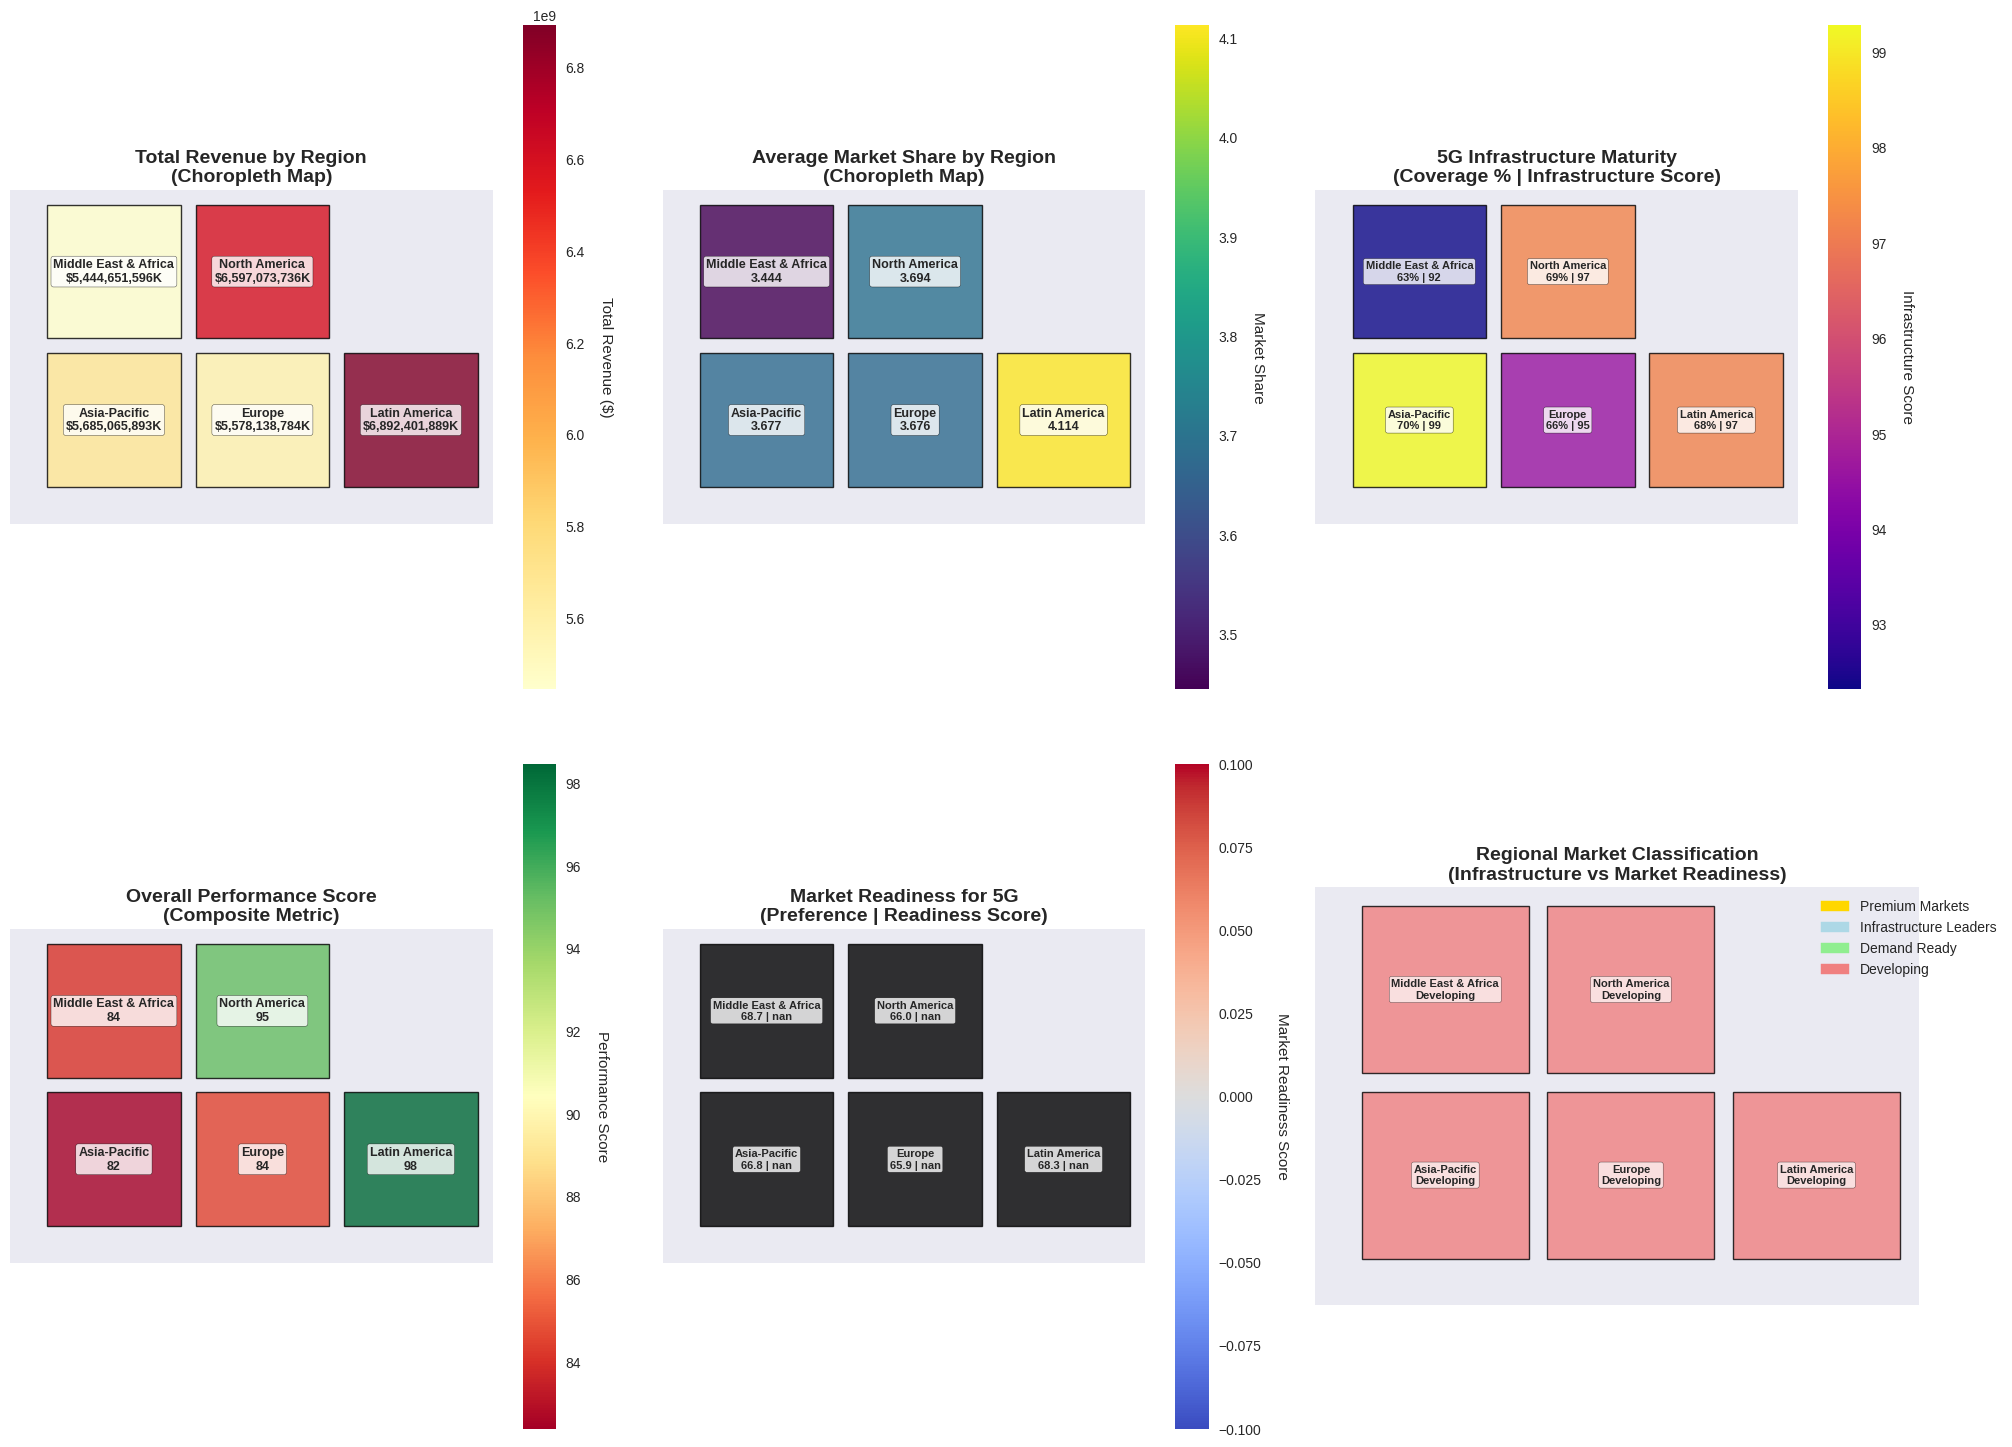


🗺️ Geospatial Analysis Summary:
Total regions analyzed: 5

📊 Performance Leaders:
Highest Revenue: Latin America ($6,892,401,889K)
Highest Market Share: Latin America (4.114)
Best Overall Performance: Latin America (Score: 98)

🏗️ Infrastructure Leaders:
Best Infrastructure: Asia-Pacific (Score: 99)
Highest 5G Coverage: Asia-Pacific (69.7%)

🎯 Market Classification:
Developing: 5 regions (100.0%)

🔗 Key Correlations:
Infrastructure-Performance Correlation: 0.274
Market Readiness-Performance Correlation: nan


In [29]:
# ========================================
# SECTION 4: ADVANCED ANALYTICS MODULE 3
# GEOSPATIAL SALES ANALYSIS - CHOROPLETH VISUALIZATIONS
# ========================================

def geospatial_sales_analysis_choropleth(df):
    """
    Comprehensive Geospatial Sales Analysis using Choropleth Map Visualizations
    Analyzes sales performance across different regions using color-coded regional maps
    """
    print("🗺️ Performing Geospatial Sales Analysis with Choropleth Maps...")

    # Create time mapping for temporal analysis
    quarter_map = {"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4}
    df['Time_Code'] = df['Year'] * 4 + df['Quarter'].map(quarter_map)

    # Aggregate regional metrics
    regional_summary = df.groupby('Region').agg({
        'Units_Sold': ['sum', 'mean', 'std'],
        'Revenue': ['sum', 'mean', 'std'],
        'Market_Share': ['mean', 'max', 'std'],
        'Regional_5G_Coverage': 'mean',
        '5G_Subscribers_millions': 'mean',
        'Avg_5G_Speed_Mbps': 'mean',
        'Preference_for_5G': 'mean',
        'Time_Code': ['min', 'max', 'count'],
        '5G_Capability': lambda x: (x == True).sum() / len(x) * 100 if len(x) > 0 else 0
    }).reset_index()

    # Flatten column names
    regional_summary.columns = [
        'Region', 'Total_Units', 'Avg_Units', 'Units_Std',
        'Total_Revenue', 'Avg_Revenue', 'Revenue_Std',
        'Avg_Market_Share', 'Peak_Market_Share', 'Market_Share_Volatility',
        'Avg_5G_Coverage', 'Avg_5G_Subscribers', 'Avg_5G_Speed',
        'Avg_5G_Preference', 'Market_Entry', 'Latest_Period', 'Market_Presence',
        'Pct_5G_Products'
    ]

    # Calculate composite scores
    regional_summary['Performance_Score'] = (
        (regional_summary['Total_Revenue'] / regional_summary['Total_Revenue'].max()) * 0.4 +
        (regional_summary['Avg_Market_Share'] / regional_summary['Avg_Market_Share'].max()) * 0.3 +
        (regional_summary['Total_Units'] / regional_summary['Total_Units'].max()) * 0.3
    ) * 100

    regional_summary['Infrastructure_Score'] = (
        (regional_summary['Avg_5G_Coverage'] / regional_summary['Avg_5G_Coverage'].max()) * 0.3 +
        (regional_summary['Avg_5G_Speed'] / regional_summary['Avg_5G_Speed'].max()) * 0.3 +
        (regional_summary['Avg_5G_Subscribers'] / regional_summary['Avg_5G_Subscribers'].max()) * 0.4
    ) * 100

    regional_summary['Market_Readiness'] = (
        (regional_summary['Avg_5G_Preference'] / regional_summary['Avg_5G_Preference'].max()) * 0.6 +
        (regional_summary['Pct_5G_Products'] / regional_summary['Pct_5G_Products'].max()) * 0.4
    ) * 100

    # Create mock regional boundaries for choropleth visualization
    # In real implementation, you'd use actual geographic shapefiles
    def create_mock_regional_grid(regions, grid_cols=None):
        n_regions = len(regions)
        if grid_cols is None:
            grid_cols = int(np.ceil(np.sqrt(n_regions)))
        grid_rows = int(np.ceil(n_regions / grid_cols))

        region_coords = {}
        for i, region in enumerate(regions):
            row = i // grid_cols
            col = i % grid_cols
            # Create rectangle coordinates (x, y, width, height)
            region_coords[region] = {
                'x': col * 2,
                'y': row * 2,
                'width': 1.8,
                'height': 1.8,
                'center_x': col * 2 + 0.9,
                'center_y': row * 2 + 0.9
            }
        return region_coords

    region_coords = create_mock_regional_grid(regional_summary['Region'].tolist())

    # Create comprehensive choropleth visualizations
    fig = plt.figure(figsize=(20, 16))

    # 1. Revenue Performance Choropleth (Top Left)
    ax1 = plt.subplot(2, 3, 1)

    # Normalize revenue for color mapping
    revenue_norm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=regional_summary['Total_Revenue'].min(),
                          vmax=regional_summary['Total_Revenue'].max()),
        cmap='YlOrRd'
    )

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = revenue_norm.to_rgba(row['Total_Revenue'])

        # Draw regional rectangle
        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax1.add_patch(rect)

        # Add region label and value
        ax1.text(coords['center_x'], coords['center_y'], f"{region}\n${row['Total_Revenue']:,.0f}K",
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax1.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax1.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax1.set_title('Total Revenue by Region\n(Choropleth Map)', fontsize=14, fontweight='bold')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_aspect('equal')

    # Add colorbar
    cbar1 = plt.colorbar(revenue_norm, ax=ax1, shrink=0.8)
    cbar1.set_label('Total Revenue ($)', rotation=270, labelpad=20)

    # 2. Market Share Choropleth (Top Middle)
    ax2 = plt.subplot(2, 3, 2)

    market_share_norm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=regional_summary['Avg_Market_Share'].min(),
                          vmax=regional_summary['Avg_Market_Share'].max()),
        cmap='viridis'
    )

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = market_share_norm.to_rgba(row['Avg_Market_Share'])

        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax2.add_patch(rect)

        ax2.text(coords['center_x'], coords['center_y'], f"{region}\n{row['Avg_Market_Share']:.3f}",
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax2.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax2.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax2.set_title('Average Market Share by Region\n(Choropleth Map)', fontsize=14, fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_aspect('equal')

    cbar2 = plt.colorbar(market_share_norm, ax=ax2, shrink=0.8)
    cbar2.set_label('Market Share', rotation=270, labelpad=20)

    # 3. 5G Infrastructure Choropleth (Top Right)
    ax3 = plt.subplot(2, 3, 3)

    infrastructure_norm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=regional_summary['Infrastructure_Score'].min(),
                          vmax=regional_summary['Infrastructure_Score'].max()),
        cmap='plasma'
    )

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = infrastructure_norm.to_rgba(row['Infrastructure_Score'])

        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax3.add_patch(rect)

        ax3.text(coords['center_x'], coords['center_y'],
                f"{region}\n{row['Avg_5G_Coverage']:.0f}% | {row['Infrastructure_Score']:.0f}",
                ha='center', va='center', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax3.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax3.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax3.set_title('5G Infrastructure Maturity\n(Coverage % | Infrastructure Score)',
                  fontsize=14, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_aspect('equal')

    cbar3 = plt.colorbar(infrastructure_norm, ax=ax3, shrink=0.8)
    cbar3.set_label('Infrastructure Score', rotation=270, labelpad=20)

    # 4. Performance Score Choropleth (Bottom Left)
    ax4 = plt.subplot(2, 3, 4)

    performance_norm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=regional_summary['Performance_Score'].min(),
                          vmax=regional_summary['Performance_Score'].max()),
        cmap='RdYlGn'
    )

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = performance_norm.to_rgba(row['Performance_Score'])

        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax4.add_patch(rect)

        ax4.text(coords['center_x'], coords['center_y'], f"{region}\n{row['Performance_Score']:.0f}",
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax4.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax4.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax4.set_title('Overall Performance Score\n(Composite Metric)', fontsize=14, fontweight='bold')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_aspect('equal')

    cbar4 = plt.colorbar(performance_norm, ax=ax4, shrink=0.8)
    cbar4.set_label('Performance Score', rotation=270, labelpad=20)

    # 5. Market Readiness Choropleth (Bottom Middle)
    ax5 = plt.subplot(2, 3, 5)

    readiness_norm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=regional_summary['Market_Readiness'].min(),
                          vmax=regional_summary['Market_Readiness'].max()),
        cmap='coolwarm'
    )

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = readiness_norm.to_rgba(row['Market_Readiness'])

        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax5.add_patch(rect)

        ax5.text(coords['center_x'], coords['center_y'],
                f"{region}\n{row['Avg_5G_Preference']:.1f} | {row['Market_Readiness']:.0f}",
                ha='center', va='center', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax5.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax5.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax5.set_title('Market Readiness for 5G\n(Preference | Readiness Score)',
                  fontsize=14, fontweight='bold')
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.set_aspect('equal')

    cbar5 = plt.colorbar(readiness_norm, ax=ax5, shrink=0.8)
    cbar5.set_label('Market Readiness Score', rotation=270, labelpad=20)

    # 6. Regional Classification Matrix (Bottom Right)
    ax6 = plt.subplot(2, 3, 6)

    # Create 2x2 matrix: Infrastructure vs Market Readiness
    infra_median = regional_summary['Infrastructure_Score'].median()
    readiness_median = regional_summary['Market_Readiness'].median()

    # Classify regions into quadrants
    regional_summary['Market_Type'] = 'Developing'
    regional_summary.loc[
        (regional_summary['Infrastructure_Score'] >= infra_median) &
        (regional_summary['Market_Readiness'] >= readiness_median), 'Market_Type'
    ] = 'Premium Markets'
    regional_summary.loc[
        (regional_summary['Infrastructure_Score'] >= infra_median) &
        (regional_summary['Market_Readiness'] < readiness_median), 'Market_Type'
    ] = 'Infrastructure Leaders'
    regional_summary.loc[
        (regional_summary['Infrastructure_Score'] < infra_median) &
        (regional_summary['Market_Readiness'] >= readiness_median), 'Market_Type'
    ] = 'Demand Ready'

    # Color mapping for market types
    type_colors = {
        'Premium Markets': 'gold',
        'Infrastructure Leaders': 'lightblue',
        'Demand Ready': 'lightgreen',
        'Developing': 'lightcoral'
    }

    for _, row in regional_summary.iterrows():
        region = row['Region']
        coords = region_coords[region]
        color = type_colors[row['Market_Type']]

        rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                        facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
        ax6.add_patch(rect)

        ax6.text(coords['center_x'], coords['center_y'], f"{region}\n{row['Market_Type']}",
                ha='center', va='center', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

    ax6.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
    ax6.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
    ax6.set_title('Regional Market Classification\n(Infrastructure vs Market Readiness)',
                  fontsize=14, fontweight='bold')
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax6.set_aspect('equal')

    # Add legend for market types
    legend_patches = [mpatches.Patch(color=color, label=market_type)
                     for market_type, color in type_colors.items()]
    ax6.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.tight_layout()
    plt.show()

    # Print comprehensive summary
    print("\n🗺️ Geospatial Analysis Summary:")
    print(f"Total regions analyzed: {len(regional_summary)}")

    print("\n📊 Performance Leaders:")
    top_revenue = regional_summary.loc[regional_summary['Total_Revenue'].idxmax()]
    top_market_share = regional_summary.loc[regional_summary['Avg_Market_Share'].idxmax()]
    top_performance = regional_summary.loc[regional_summary['Performance_Score'].idxmax()]

    print(f"Highest Revenue: {top_revenue['Region']} (${top_revenue['Total_Revenue']:,.0f}K)")
    print(f"Highest Market Share: {top_market_share['Region']} ({top_market_share['Avg_Market_Share']:.3f})")
    print(f"Best Overall Performance: {top_performance['Region']} (Score: {top_performance['Performance_Score']:.0f})")

    print("\n🏗️ Infrastructure Leaders:")
    top_infrastructure = regional_summary.loc[regional_summary['Infrastructure_Score'].idxmax()]
    top_coverage = regional_summary.loc[regional_summary['Avg_5G_Coverage'].idxmax()]
    print(f"Best Infrastructure: {top_infrastructure['Region']} (Score: {top_infrastructure['Infrastructure_Score']:.0f})")
    print(f"Highest 5G Coverage: {top_coverage['Region']} ({top_coverage['Avg_5G_Coverage']:.1f}%)")

    print("\n🎯 Market Classification:")
    market_type_counts = regional_summary['Market_Type'].value_counts()
    for market_type, count in market_type_counts.items():
        print(f"{market_type}: {count} regions ({count/len(regional_summary)*100:.1f}%)")

    print("\n🔗 Key Correlations:")
    infra_perf_corr = regional_summary['Infrastructure_Score'].corr(regional_summary['Performance_Score'])
    readiness_perf_corr = regional_summary['Market_Readiness'].corr(regional_summary['Performance_Score'])
    print(f"Infrastructure-Performance Correlation: {infra_perf_corr:.3f}")
    print(f"Market Readiness-Performance Correlation: {readiness_perf_corr:.3f}")

    return regional_summary, region_coords

regional_data = geospatial_sales_analysis_choropleth(df)

📈 Creating Temporal Choropleth Analysis for Units_Sold...


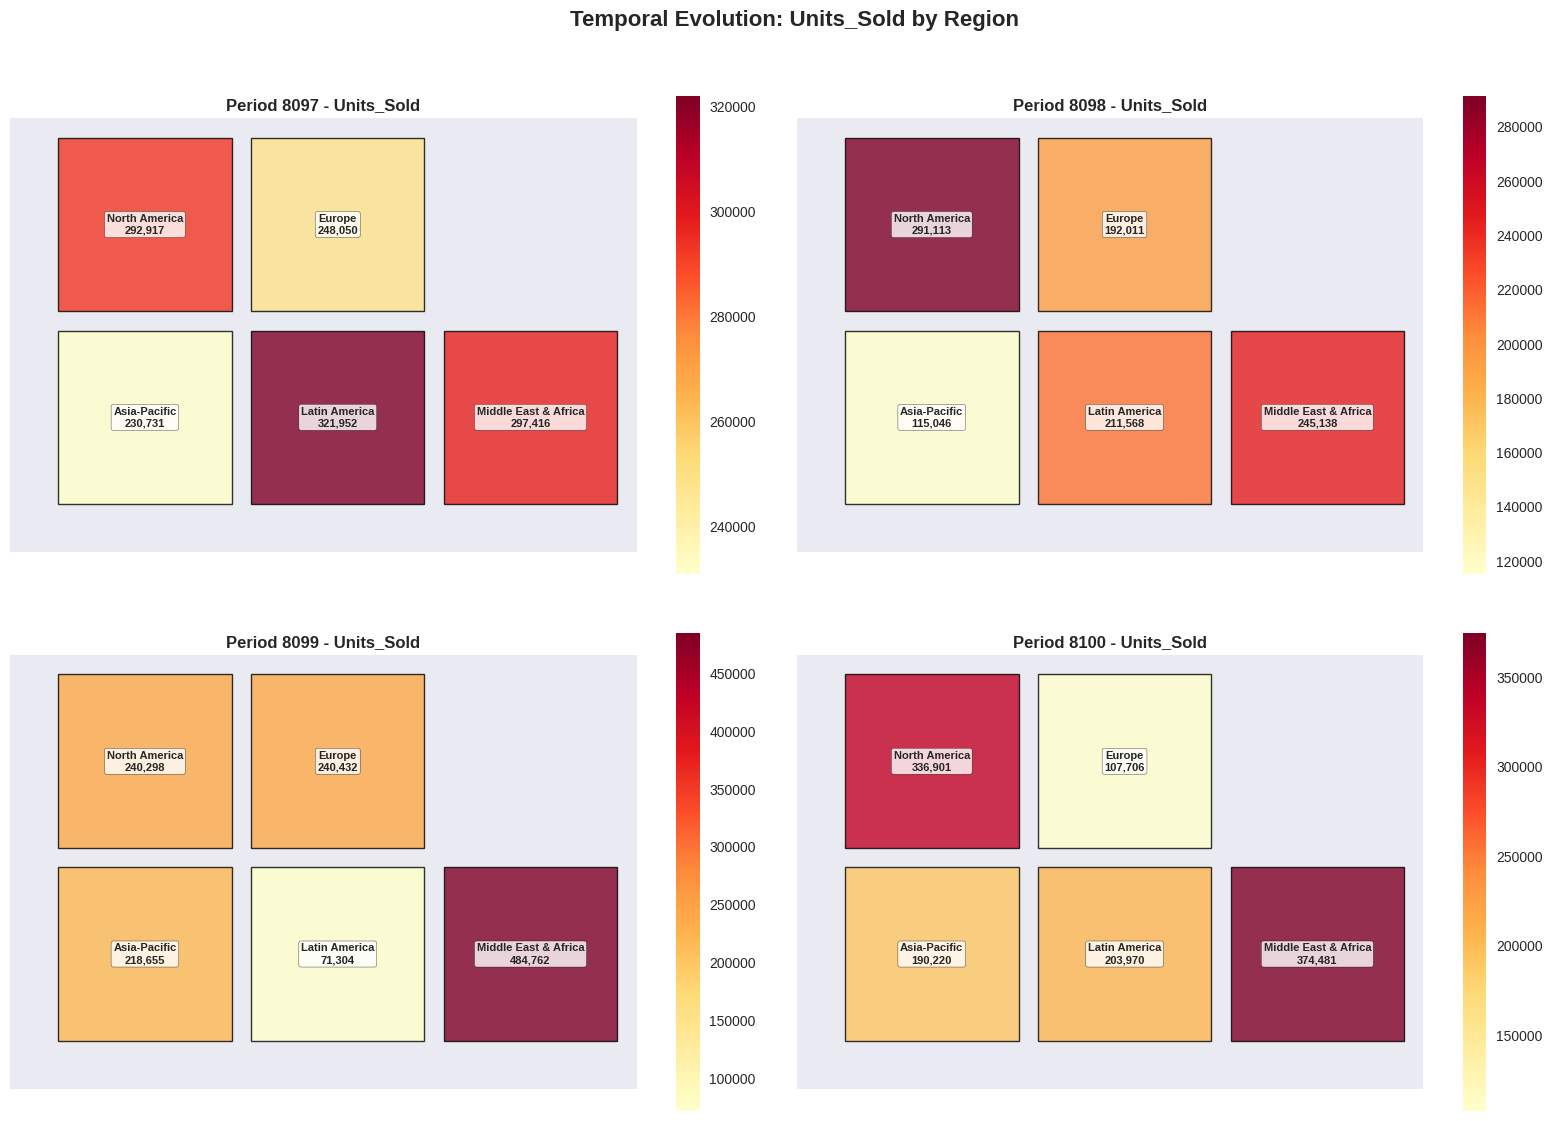

In [30]:
# ========================================
# SECTION 4: ADVANCED ANALYTICS MODULE 4
# TEMPORAL CHOROPLETH ANALYSIS
# ========================================

# Function to create temporal choropleth analysis
def temporal_choropleth_analysis(df, metric='Revenue', time_periods=None):
    """
    Create time-based choropleth maps showing how regions evolve over time
    """
    print(f"📈 Creating Temporal Choropleth Analysis for {metric}...")

    quarter_map = {"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4}
    df['Time_Code'] = df['Year'] * 4 + df['Quarter'].map(quarter_map)

    if time_periods is None:
        time_periods = sorted(df['Time_Code'].unique())[-4:]  # Last 4 periods

    # Create regional grid coordinates
    regions = df['Region'].unique()
    region_coords = {}
    grid_cols = int(np.ceil(np.sqrt(len(regions))))

    for i, region in enumerate(regions):
        row = i // grid_cols
        col = i % grid_cols
        region_coords[region] = {
            'x': col * 2, 'y': row * 2, 'width': 1.8, 'height': 1.8,
            'center_x': col * 2 + 0.9, 'center_y': row * 2 + 0.9
        }

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, time_period in enumerate(time_periods[:4]):
        ax = axes[idx]

        # Get data for this time period
        period_data = df[df['Time_Code'] == time_period].groupby('Region')[metric].sum().reset_index()

        if len(period_data) == 0:
            continue

        # Normalize values for color mapping
        norm = plt.cm.ScalarMappable(
            norm=plt.Normalize(vmin=period_data[metric].min(), vmax=period_data[metric].max()),
            cmap='YlOrRd'
        )

        for _, row in period_data.iterrows():
            region = row['Region']
            if region not in region_coords:
                continue

            coords = region_coords[region]
            color = norm.to_rgba(row[metric])

            rect = Rectangle((coords['x'], coords['y']), coords['width'], coords['height'],
                            facecolor=color, edgecolor='black', linewidth=1, alpha=0.8)
            ax.add_patch(rect)

            ax.text(coords['center_x'], coords['center_y'], f"{region}\n{row[metric]:,.0f}",
                   ha='center', va='center', fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

        ax.set_xlim(-0.5, max([coord['x'] for coord in region_coords.values()]) + 2)
        ax.set_ylim(-0.5, max([coord['y'] for coord in region_coords.values()]) + 2)
        ax.set_title(f'Period {time_period} - {metric}', fontsize=12, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

        plt.colorbar(norm, ax=ax, shrink=0.8)

    plt.suptitle(f'Temporal Evolution: {metric} by Region', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

temporal_choropleth_analysis(df, metric='Units_Sold')